In [32]:
%matplotlib inline 

import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam

In [33]:
img_rows = 28
img_cols = 28
channels = 1

# 入力画像の次元
img_shape = (img_rows, img_cols, channels)

# 生成器の入力として使われるノイズベクトルの次元
z_dim = 100

## 生成器のモデル

In [34]:
def build_generator(img_shape, z_dim):
    
    model = Sequential()
    
    # 全結合層
    model.add(Dense(128, input_dim=z_dim))
    
    # Leaky ReLUによる活性化
    model.add(LeakyReLU(alpha=0.01))
    
    # tanh関数による出力層
    model.add(Dense(28 * 28 * 1, activation='tanh'))
    
    # 生成器の出力が画像サイズになるようにreshapeする
    model.add(Reshape(img_shape))
    
    return model

## 識別器のモデル

In [35]:
def build_discriminator(img_shape):
    
    model = Sequential()
    
    # 入力画像を一列に並べる
    model.add(Flatten(input_shape=img_shape))
    
    # 全結合層
    model.add(Dense(128))
    
    # Leaky ReLUによる活性化
    model.add(LeakyReLU(alpha=0.01))
    
    # sigmoid関数を通して出力する
    model.add(Dense(1, activation='sigmoid'))
    
    return model

## GANの構築とコンパイル

In [38]:
def build_gan(generator, discriminator):
    
    model = Sequential()
    
    # 生成器と識別器の結合
    model.add(generator)
    model.add(discriminator)
    
    return model
# 識別器の構築とコンパイル
discriminator = build_discriminator(img_shape)

# 生成器の構築中は識別器のパラメータを固定
discriminator.compile(loss='binary_crossentropy',
                     optimizer=Adam(),
                     metrics=['accuracy'])

# 生成器の構築
generator = build_generator(img_shape, z_dim)

# 生成器の構築中は識別器のパラメータを固定する
discriminator.tranable = False

# 生成器の訓練のため、識別器は固定し、GANモデルの構築とコンパイルを行う
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

## GANの訓練ループ

In [39]:
## GANの訓練ループ
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
    
    # MNISTデータセットのロード
    (X_train, _), (_, _) = mnist.load_data()
    
    # [0,255]の範囲のグレースケールがそちを[-1, 1]にスケーリング
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)
    
    # 本物の画像のラベルは全て１とする
    real = np.ones((batch_size, 1))
    
    # 偽の画像のラベルは全て０とする
    fake = np.zeros((batch_size, 1))
    
    for iteration in range(iterations):
        
        # -------------------
        # 識別器の訓練
        # -------------------
        
        # 本物の画像のランダムに取り出したバッチを作る
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        
        #偽の画像のランダムに取り出したバッチを生成する
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)
        
        # 識別器の訓練
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # -----------------
        # 生成器の訓練
        # -----------------
        
        # 偽の画像のバッチを生成する
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)
        
        # 生成器の訓練
        g_loss = gan.train_on_batch(z, real)
        
        if (iteration + 1) % sample_interval == 0:
            
            # 訓練終了後に図時するために、損失を精度をセーブしておく
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)
            
            # 訓練の進捗を出力する
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                 (iteration + 1, d_loss, 100.0 * accuracy, g_loss))
            
            # 生成された画像のサンプルを出力する
            sample_images(generator)

## 生成された画像の表示

In [44]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    # Sample random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # Generate images from random noise
    gen_imgs = generator.predict(z)

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1


## モデルを実行する

1000 [D loss: 0.035592, acc.: 100.00%] [G loss: 2.839366]
2000 [D loss: 0.023689, acc.: 100.00%] [G loss: 3.396059]
3000 [D loss: 0.013425, acc.: 100.00%] [G loss: 3.853878]
4000 [D loss: 0.008693, acc.: 100.00%] [G loss: 4.174785]
5000 [D loss: 0.005049, acc.: 100.00%] [G loss: 4.681804]
6000 [D loss: 0.003206, acc.: 100.00%] [G loss: 5.159404]
7000 [D loss: 0.001955, acc.: 100.00%] [G loss: 5.696808]
8000 [D loss: 0.001222, acc.: 100.00%] [G loss: 6.293609]
9000 [D loss: 0.000646, acc.: 100.00%] [G loss: 7.616601]
10000 [D loss: 0.085951, acc.: 98.83%] [G loss: 7.726583]
11000 [D loss: 0.309878, acc.: 88.28%] [G loss: 12.208633]
12000 [D loss: 0.087413, acc.: 98.05%] [G loss: 11.067181]
13000 [D loss: 0.138892, acc.: 96.09%] [G loss: 9.492666]
14000 [D loss: 0.113173, acc.: 94.92%] [G loss: 11.577745]
15000 [D loss: 8.501554, acc.: 75.78%] [G loss: 78.813232]
16000 [D loss: 1.409693, acc.: 79.30%] [G loss: 29.694828]
17000 [D loss: 0.603733, acc.: 88.28%] [G loss: 33.335045]
18000 [D

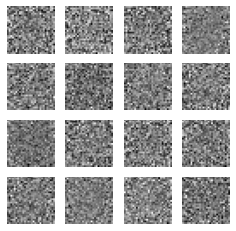

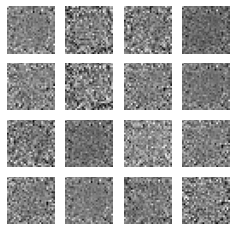

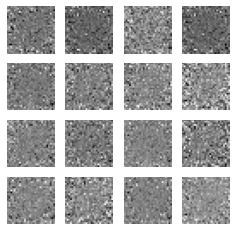

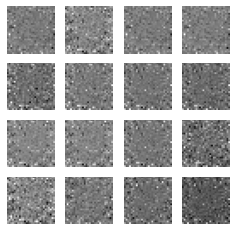

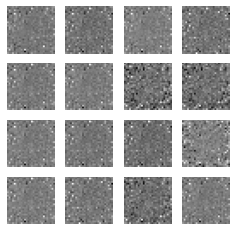

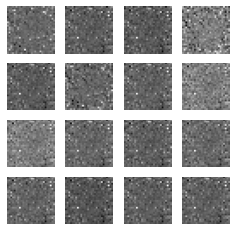

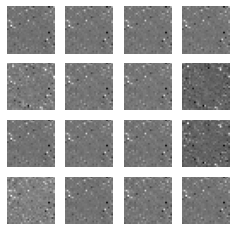

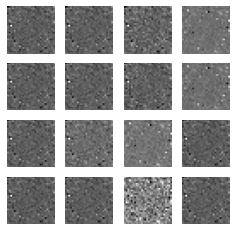

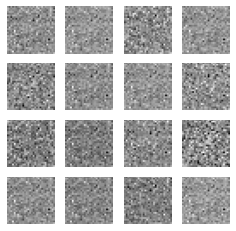

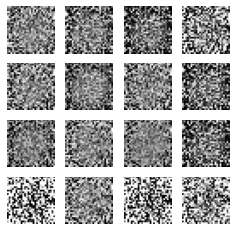

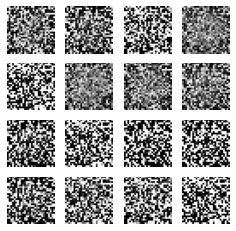

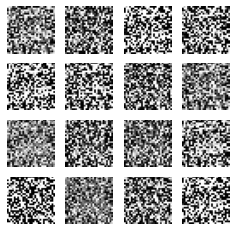

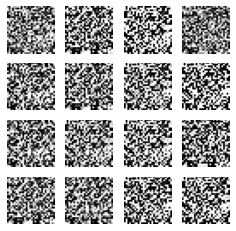

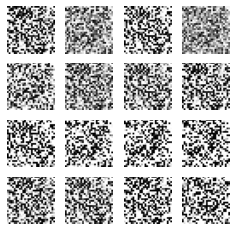

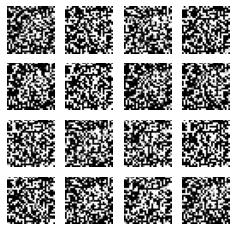

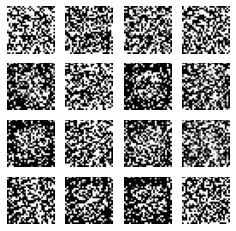

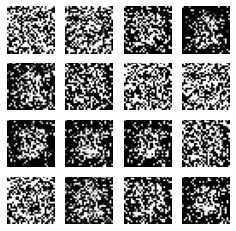

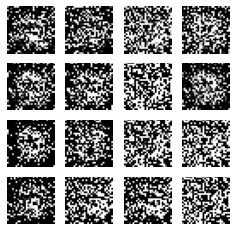

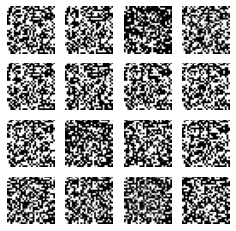

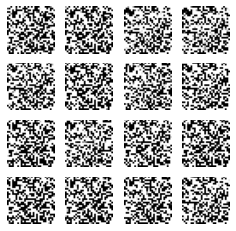

In [45]:
# ハイパーパラメータの設定
iterations = 20000
batch_size = 128
sample_interval = 1000

# 設定した反復回数だけGANの訓練を行う
train(iterations, batch_size, sample_interval)